In [ ]:
import zipfile
local_zip = './img.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./')
zip_ref.close()

In [ ]:
!pip install -U --pre tensorflow=="2.*"
!pip install pycocotools

     |████████████████████████████████| 516.2MB 33kB/s 
  Found existing installation: tensorflow 2.2.0rc3
    Uninstalling tensorflow-2.2.0rc3:
      Successfully uninstalled tensorflow-2.2.0rc3


In [ ]:
import os
import pathlib


if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2571, done.
remote: Counting objects: 100% (2571/2571), done.
remote: Compressing objects: 100% (2239/2239), done.
remote: Total 2571 (delta 500), reused 1366 (delta 295), pack-reused 0
Receiving objects: 100% (2571/2571), 124.07 MiB | 15.29 MiB/s, done.
Resolving deltas: 100% (500/500), done.
Checking out files: 100% (2483/2483), done.


In [ ]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.

In [ ]:
%%bash 
cd models/research
pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1017525 sha256=168c9fa5a5c2dd0993729dd768ff1504d374f3d1be21318b891004d7b29e1b54
  Stored in directory: /tmp/pip-ephem-wheel-cache-uuwieeg9/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
Successfully built object-detection


In [ ]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

In [ ]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [ ]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

In [ ]:
def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)

  model_dir = pathlib.Path(model_dir)/"saved_model"

  model = tf.saved_model.load(str(model_dir))
  model = model.signatures['serving_default']

  return model

In [ ]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [ ]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('models/research/object_detection/test_images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS

[PosixPath('models/research/object_detection/test_images/image1.jpg'),
 PosixPath('models/research/object_detection/test_images/image2.jpg')]

In [ ]:
model_name = 'ssd_mobilenet_v1_coco_2017_11_17'
detection_model = load_model(model_name)

76537856/76534733 [==============================] - 1s 0us/step
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
print(detection_model.inputs)

[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]


In [ ]:
detection_model.output_dtypes

{'detection_boxes': tf.float32,
 'detection_classes': tf.float32,
 'detection_scores': tf.float32,
 'num_detections': tf.float32}

In [ ]:
detection_model.output_shapes

{'detection_boxes': TensorShape([None, 100, 4]),
 'detection_classes': TensorShape([None, 100]),
 'detection_scores': TensorShape([None, 100]),
 'num_detections': TensorShape([None])}

In [ ]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  output_dict = model(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

In [ ]:
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=2)

  display(Image.fromarray(image_np))
  return output_dict

In [ ]:
model_name = "mask_rcnn_inception_resnet_v2_atrous_coco_2018_01_28"
masking_model = load_model(model_name)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
masking_model.output_shapes

{'detection_boxes': TensorShape([None, 100, 4]),
 'detection_classes': TensorShape([None, 100]),
 'detection_masks': TensorShape([None, None, None, None]),
 'detection_scores': TensorShape([None, 100]),
 'num_detections': TensorShape([None])}

***Calibration***

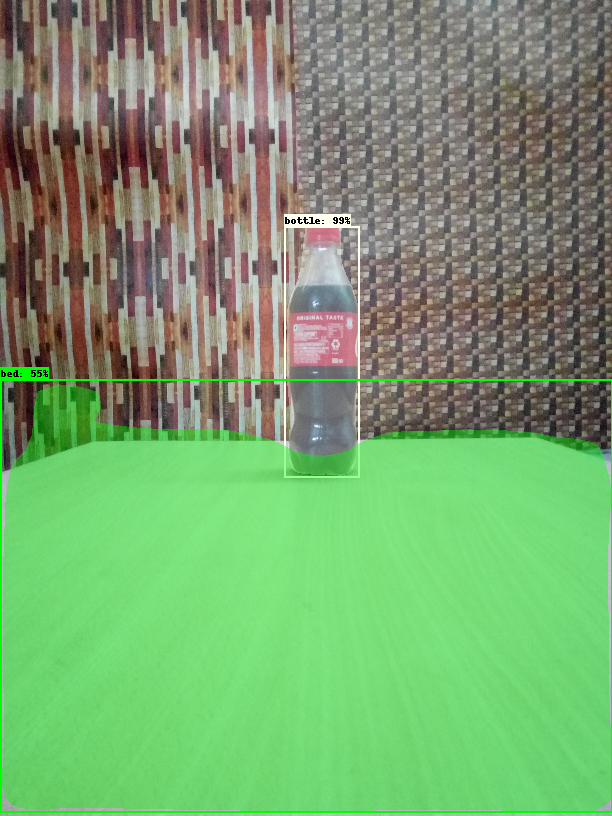

In [ ]:
op = show_inference(masking_model, './img/60c.jpg')

In [ ]:
op 

{'detection_boxes': array([[0.27840906, 0.46487045, 0.5840471 , 0.58738405],
        [0.4668708 , 0.        , 0.9940911 , 1.        ]], dtype=float32),
 'detection_classes': array([44, 65]),
 'detection_masks': array([[[7.7625678e-04, 1.5523292e-04, 1.8369802e-04, ...,
          5.5389886e-04, 3.7362817e-04, 1.1787827e-03],
         [1.8419983e-04, 1.1117754e-04, 2.0837146e-04, ...,
          6.7416509e-04, 2.5459612e-04, 2.9964204e-04],
         [1.6029511e-04, 1.6002161e-04, 3.3449536e-04, ...,
          1.0297608e-03, 4.1442434e-04, 2.8267666e-04],
         ...,
         [2.2170026e-02, 1.2576446e-01, 4.9291354e-01, ...,
          6.9008923e-01, 2.6854774e-01, 6.0841657e-02],
         [8.1717977e-03, 3.8501509e-02, 1.7560145e-01, ...,
          3.0414155e-01, 8.6011797e-02, 2.1140531e-02],
         [6.1486927e-03, 9.2635360e-03, 2.1992769e-02, ...,
          5.3818494e-02, 2.0866746e-02, 1.6744232e-02]],
 
        [[1.0557610e-01, 2.1165881e-01, 4.3002096e-01, ...,
          6.98270

In [ ]:
import cv2
import numpy as np

In [ ]:
img = cv2.imread('./img/60c.jpg') 

In [ ]:
shape = img.shape

In [ ]:
shape

(816, 612, 3)

In [ ]:
bbox = op['detection_boxes'][0]

In [ ]:
bbox = [bbox[0]*shape[0],bbox[1]*shape[1],bbox[2]*shape[0],bbox[3]*shape[1]]

In [ ]:
h = int(bbox[2]-bbox[0])
w = int(bbox[3]-bbox[1])

In [ ]:
''' Calibration function takes size of an object in image at known distance from camera and actual size of object
and calibrates the distance function. The method is based on working principle of pinhole camera.

calculations are done considering the angle of view to be neglegible.'''

#actual_height is actual height of object in any unit
#height is height of object in image in pixels
#distance is actual distance of object from camera for calibration in any unit
# assuming we have bounding boxes which are in order[x,y,height,width] x,y are co-ordinates of bottom left corner 


import math

def calibrate(actual_height, height, distance):
	return (distance*height)/actual_height

d = calibrate(23, h, 60)
print(d)

649.5652173913044


In [ ]:
#obj_height is actual height of object for which distance is being measured
#height is height of object in image in pixels
#d is calibration value which will be specific for each camera 

# function measure_distance gives distance of object from camera
def measure_distance(obj_height, d, height):
	return (obj_height*d)/height

# function long_distance for longitudinal distance

def long_distance(bbox1, bbox2, oh1, oh2, d):
  h1 = int(bbox1[2]-bbox1[0])
  h2 = int(bbox2[2]-bbox2[0])
  d1 = measure_distance(oh1, d, h1)
  d2 = measure_distance(oh2, d, h2)
  return abs(d1-d2)

# function lat_distance for lateral distance between objects

def lat_distance(bbox1, bbox2, oh1, d):
  x1 = int(bbox1[1])
  x2 = int(bbox2[1])
  w1 = int(bbox1[3]-bbox1[1])
  w2 = int(bbox2[3]-bbox2[1])
  h1 = int(bbox1[2]-bbox1[0])
  midx1 = x1 + w1/2
  midx2 = x2 + w2/2
  dis = abs(midx1 - midx2)
  d1 = measure_distance(oh1, d, h1)
  actual_dis = (dis*d1)/d
  return actual_dis

# function get distance combines both lateral and longitudinal distances and gives total distance 

def get_distance(bbox1, bbox2, oh1, oh2, d):
	y = long_distance(bbox1, bbox2, oh1, oh2, d)
	x = lat_distance(bbox1, bbox2, oh1, d)
	return math.sqrt(x**2 + y**2)


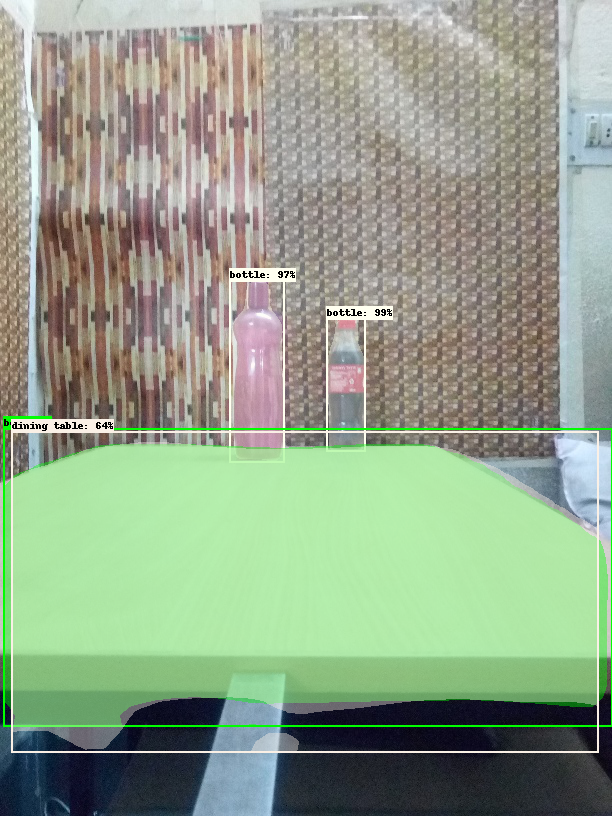

In [ ]:
opt = show_inference(masking_model, './img/100_114_14_15.jpg')

In [ ]:
opt

{'detection_boxes': array([[0.39162356, 0.5342088 , 0.55242395, 0.59785485],
        [0.34494162, 0.3744207 , 0.5652532 , 0.46442237],
        [0.526935  , 0.00555775, 0.889189  , 1.        ],
        [0.5299616 , 0.01910996, 0.9211632 , 0.97735953]], dtype=float32),
 'detection_classes': array([44, 44, 65, 67]),
 'detection_masks': array([[[6.2725618e-03, 2.6401633e-03, 3.6196003e-03, ...,
          7.3337848e-03, 4.0050196e-03, 6.5670954e-03],
         [4.0347325e-03, 5.0576366e-03, 1.0067318e-02, ...,
          9.9076396e-03, 3.5899763e-03, 2.5934328e-03],
         [6.5643424e-03, 1.3329298e-02, 2.9032584e-02, ...,
          1.3275399e-02, 5.3930399e-03, 2.8414489e-03],
         ...,
         [2.0586632e-01, 3.8147819e-01, 5.8442670e-01, ...,
          6.9580108e-01, 4.4238985e-01, 2.2419468e-01],
         [1.8127802e-01, 3.2614997e-01, 5.0867504e-01, ...,
          5.6639117e-01, 3.2688704e-01, 1.6012874e-01],
         [1.4578381e-01, 1.8543972e-01, 2.6970363e-01, ...,
          2.

In [ ]:
bbox1 = opt['detection_boxes'][0]
bbox2 = opt['detection_boxes'][1]

In [ ]:
bbox1 = [bbox1[0]*shape[0],bbox1[1]*shape[1],bbox1[2]*shape[0],bbox1[3]*shape[1]]
bbox2 = [bbox2[0]*shape[0],bbox2[1]*shape[1],bbox2[2]*shape[0],bbox2[3]*shape[1]]

In [ ]:
get_distance(bbox1, bbox2, 23, 28, d)

19.9031251679806